# Imports

In [1]:
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from time import time

from torchvision import datasets
from torchvision.transforms import ToTensor

from matplotlib import pyplot as plt

# Load dataset

In [2]:
def load_mnist(batch_size):

    root = "C:/Users/edvin/GitHub/DeepImg/A3/MNIST/"
    
    # Load the dataset
    train_data = datasets.MNIST(root+"Train", train=True, download=False, transform=ToTensor())
    test_data = datasets.MNIST(root+"Test", train=False, download=False, transform=ToTensor())

    # Create dataloaders
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=len(test_data), shuffle=False)

    return train_loader, test_loader

In [3]:
train_loader, test_loader = load_mnist(100)
for batch_idx, (data, labels) in enumerate(train_loader):
    
    print(f"data.shape: {data.shape}\n")
    
    print(f"  Nr of images: {data.shape[0]}")
    print(f"  Channels: {data.shape[1]}")
    print(f"  Width: {data.shape[2]}")
    print(f"  Height: {data.shape[3]}")

    
    print()
    print("Reshape data")
    X = data.reshape(data.shape[0],-1)
    print("  dim(X):",X.shape)
    
    break

data.shape: torch.Size([100, 1, 28, 28])

  Nr of images: 100
  Channels: 1
  Width: 28
  Height: 28

Reshape data
  dim(X): torch.Size([100, 784])


In [4]:
train_loader, test_loader = load_mnist(100)
for batch_idx, (data, labels) in enumerate(test_loader):
    
    print(f"data.shape: {data.shape}\n")
    
    print(f"  Nr of images: {data.shape[0]}")
    print(f"  Channels: {data.shape[1]}")
    print(f"  Width: {data.shape[2]}")
    print(f"  Height: {data.shape[3]}")

    
    print()
    print("Reshape data")
    X = data.reshape(data.shape[0],-1)
    print("  dim(X):",X.shape)
    
    break

data.shape: torch.Size([10000, 1, 28, 28])

  Nr of images: 10000
  Channels: 1
  Width: 28
  Height: 28

Reshape data
  dim(X): torch.Size([10000, 784])


# Define Neural Network

In [5]:
class Fully_Connected_Network(nn.Module):
    def __init__(self):
        # Superclass constructor
        super().__init__()
        
        # Layers   Z = X*W + B
        # Z1 = X*W1,   dim(Z1)=100,128    dim(X) = 100,784   dim(W1) = 784,128 
        # Z2 = A_1*W2, dim(Z2)=100,32   dim(A_1) = 100,128   dim(W2) = 128,32   
        # Z3 = A_2*W3, dim(Z3)=100,10   dim(A_2) = 100,32    dim(W3) = 32,10   
        self.W1 = nn.Linear(784,128) 
        self.W2 = nn.Linear(128,32)  
        self.W3 = nn.Linear(32,10)    
        
        # Activation functions
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, X):
        # First layer
        Z_1 = self.W1(X)
        A_1 = self.relu(Z_1)
        
        # Second layer
        Z_2 = self.W2(A_1)
        A_2 = self.relu(Z_2)
        
        # Third layer
        Z_3 = self.W3(A_2)
        Y_hat = self.softmax(Z_3)

        return Y_hat

# Accuracy function

In [6]:
def get_accuracy(output,labels):
    # How many data points
    n = labels.size(0)
    
    # Get model predictions
    _, predictions = torch.max(output, 1)
    
    # Vector of "True" or "False" if prediction matches true labels
    correct = (predictions == labels)
    
    # Count how many "True"
    total_correct = correct.sum().item()
    
    # Calculate accuracy
    acc = total_correct / n
    
    return acc

In [7]:
def test_accuracy(test_loader,model,device):
    # Load data and labels
    for data, labels in test_loader:  # Test_loader is one batch of all test data
        data = data.to(device)
        labels = labels.to(device)
        
    # Reshape data
    data = data.reshape(data.shape[0],-1)
    
    # Feed into model
    output = model(data).to(device)
    
    # Get accuracy by comparing output and labels
    acc_test = get_accuracy(output,labels) 
    
    return acc_test

# Define training loop

In [8]:
def train_model(train_loader,test_loader,learning_rate, epochs, device, loss_vec):
    
    # Define model
    model = Fully_Connected_Network().to(device)  # Select model and move to "device"
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    
    # Performance with random weights
    test_acc = test_accuracy(test_loader,model,device)
    print(f'Epoch [0/{epochs}],                                  , Test Acc: {test_acc:.5f}')
    
    # Training loop
    for epoch in range(1,epochs+1):
        for batch_idx, (data, labels) in enumerate(train_loader):
            # Move to "device"
            data = data.to(device)
            labels = labels.to(device)
            
            # Reshape input to (batch_size,784)
            data = data.reshape(data.shape[0],-1)
            
            # Model forward and backward
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            
            # Save loss
            if batch_idx%100==0:  # Save loss every 100 batches
                loss_vec.append(loss.item())
            
            
        # Accuracy on train
        acc_train = get_accuracy(output,labels)   #last mini-batch
        
        # Accuracy on test
        acc_test = test_accuracy(test_loader,model,device)
            
        # Print epoch results
        print(f'Epoch [{epoch}/{epochs}], Loss: {loss.item():.5f}, Train Acc: {acc_train:.5f}, Test Acc: {acc_test:.5f}')
    
    return model

# Train model with learning rate 0.001

In [9]:
# Hyperparameters
batch_size = 100
learning_rate = 0.001
epochs = 15

# List for storing progress
loss_vec_1 = []

# Select where to train
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Training on: {device}\n")

# Load data
train_loader,test_loader = load_mnist(batch_size)

# Train model
start = time()
model = train_model(train_loader, test_loader, learning_rate, epochs,device,loss_vec_1)
print(f"\nTotal training time: {time()-start} seconds")


Training on: cuda

Epoch [0/15],                                  , Test Acc: 0.13450
Epoch [1/15], Loss: 2.30122, Train Acc: 0.15000, Test Acc: 0.14110
Epoch [2/15], Loss: 2.30261, Train Acc: 0.13000, Test Acc: 0.14540
Epoch [3/15], Loss: 2.30321, Train Acc: 0.11000, Test Acc: 0.14870
Epoch [4/15], Loss: 2.30068, Train Acc: 0.18000, Test Acc: 0.15280
Epoch [5/15], Loss: 2.30100, Train Acc: 0.19000, Test Acc: 0.15690
Epoch [6/15], Loss: 2.30169, Train Acc: 0.15000, Test Acc: 0.16140
Epoch [7/15], Loss: 2.30049, Train Acc: 0.19000, Test Acc: 0.16430
Epoch [8/15], Loss: 2.30135, Train Acc: 0.13000, Test Acc: 0.16740
Epoch [9/15], Loss: 2.30036, Train Acc: 0.15000, Test Acc: 0.17010
Epoch [10/15], Loss: 2.29970, Train Acc: 0.16000, Test Acc: 0.17130
Epoch [11/15], Loss: 2.29819, Train Acc: 0.23000, Test Acc: 0.17200
Epoch [12/15], Loss: 2.29962, Train Acc: 0.19000, Test Acc: 0.17430
Epoch [13/15], Loss: 2.29951, Train Acc: 0.19000, Test Acc: 0.17510
Epoch [14/15], Loss: 2.30038, Train Acc

# Train model with learning rate 1

In [10]:
# Hyperparameters
batch_size = 100
learning_rate = 1
epochs = 15

# List for storing progress
loss_vec_2 = []

# Select where to train
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Training on: {device}\n")

# Load data
train_loader,test_loader = load_mnist(batch_size)

# Train model
start = time()
model = train_model(train_loader, test_loader, learning_rate, epochs,device,loss_vec_2)
print(f"\nTotal training time: {time()-start} seconds")


Training on: cuda

Epoch [0/15],                                  , Test Acc: 0.10520
Epoch [1/15], Loss: 1.61589, Train Acc: 0.85000, Test Acc: 0.84380
Epoch [2/15], Loss: 1.56409, Train Acc: 0.90000, Test Acc: 0.86770
Epoch [3/15], Loss: 1.49989, Train Acc: 0.96000, Test Acc: 0.94030
Epoch [4/15], Loss: 1.53538, Train Acc: 0.92000, Test Acc: 0.95480
Epoch [5/15], Loss: 1.47111, Train Acc: 1.00000, Test Acc: 0.96090
Epoch [6/15], Loss: 1.49072, Train Acc: 0.97000, Test Acc: 0.96660
Epoch [7/15], Loss: 1.49363, Train Acc: 0.97000, Test Acc: 0.96830
Epoch [8/15], Loss: 1.47324, Train Acc: 0.99000, Test Acc: 0.97200
Epoch [9/15], Loss: 1.48563, Train Acc: 0.97000, Test Acc: 0.97180
Epoch [10/15], Loss: 1.51364, Train Acc: 0.95000, Test Acc: 0.97360
Epoch [11/15], Loss: 1.48266, Train Acc: 0.97000, Test Acc: 0.96540
Epoch [12/15], Loss: 1.48296, Train Acc: 0.98000, Test Acc: 0.97290
Epoch [13/15], Loss: 1.51143, Train Acc: 0.95000, Test Acc: 0.97240
Epoch [14/15], Loss: 1.49045, Train Acc

# Print loss

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


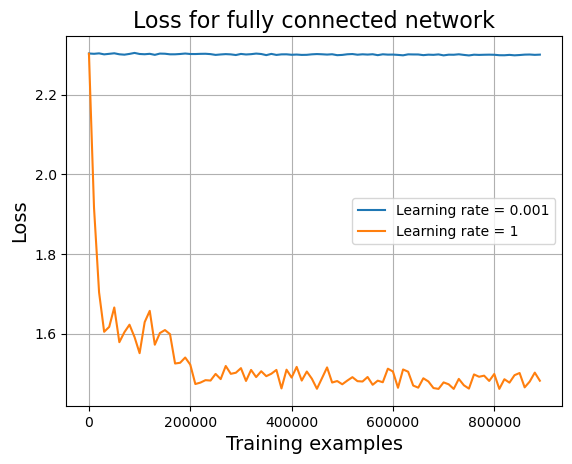

In [13]:
# Plot 1
x = range(0, len(loss_vec_1) * 10000, 10000)  #loss is calculated when model has seen 100x100 images
y1 = loss_vec_1
y2 = loss_vec_2

fig1 = plt.figure()
plt.plot(x,y1, label="Learning rate = 0.001")
plt.plot(x,y2, label="Learning rate = 1")
plt.xlabel("Training examples", fontsize=14)   # increase font size
plt.ylabel("Loss", fontsize=14)   # increase font size
plt.legend()
plt.grid()
plt.title("Loss for fully connected network", fontsize=16)   # increase font size
plt.savefig("fully_connected_loss.eps")